1. Data Cleaning & Preparation

In [13]:
import pandas as pd

# Upload files
from google.colab import files
uploaded = files.upload()



Saving course_activity.csv to course_activity (1).csv
Saving feedback.csv to feedback (1).csv
Saving students.csv to students (1).csv


In [14]:
# Load datasets
students = pd.read_csv("students.csv")
course_activity = pd.read_csv("course_activity.csv")
feedback = pd.read_csv("feedback.csv")

# Preview top rows
students.head()

print("Students")
print(students.info(), "\n")
print("Course Activity")
print(course_activity.info(), "\n")
print("Feedback")
print(feedback.info(), "\n")


Students
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Student_ID      100 non-null    object
 1   Name            100 non-null    object
 2   Age             100 non-null    int64 
 3   Gender          100 non-null    object
 4   Location        100 non-null    object
 5   Enrolment_Date  100 non-null    object
dtypes: int64(1), object(5)
memory usage: 4.8+ KB
None 

Course Activity
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Student_ID             659 non-null    object 
 1   Course_ID              659 non-null    object 
 2   Date                   659 non-null    object 
 3   Time_Spent_Minutes     659 non-null    int64  
 4   Completion_Percentage  659 non-null    flo

In [15]:
import pandas as pd
import numpy as np
from scipy import stats

# ----------------------
# STEP 1: CLEAN INDIVIDUAL DATAFRAMES
# ----------------------

# Strip whitespace from column names
students.columns = students.columns.str.strip()
course_activity.columns = course_activity.columns.str.strip()
feedback.columns = feedback.columns.str.strip()

# Drop rows with missing IDs
students.dropna(subset=['Student_ID'], inplace=True)
course_activity.dropna(subset=['Student_ID', 'Course_ID'], inplace=True)
feedback.dropna(subset=['Student_ID', 'Course_ID'], inplace=True)

# Fill missing ages with mean
students['Age'] = pd.to_numeric(students['Age'], errors='coerce')
students['Age'].fillna(students['Age'].mean(), inplace=True)

# Drop duplicates
students.drop_duplicates(inplace=True)
course_activity.drop_duplicates(inplace=True)
feedback.drop_duplicates(inplace=True)

# Convert Enrolment_Date to datetime
students['Enrolment_Date'] = pd.to_datetime(students['Enrolment_Date'], errors='coerce')

# Standardize Gender values
students['Gender'] = students['Gender'].str.strip().str.capitalize()

# Standardize location
students['Location'] = students['Location'].str.strip().str.lower()

# ----------------------
# STEP 2: MERGE DATAFRAMES
# ----------------------

# Merge all three datasets
merged_data = pd.merge(course_activity, students, on='Student_ID', how='inner')
merged_data = pd.merge(merged_data, feedback, on=['Student_ID', 'Course_ID'], how='inner')

# ----------------------
# STEP 3: CLEAN MERGED DATA
# ----------------------

# Drop any rows with missing values post-merge
merged_data.dropna(inplace=True)

# Convert Date column to datetime
merged_data['Date'] = pd.to_datetime(merged_data['Date'], errors='coerce')
merged_data.dropna(subset=['Date'], inplace=True)

# Convert Ratings and Time Spent to numeric
merged_data['Rating'] = pd.to_numeric(merged_data['Rating'], errors='coerce')
merged_data['Time_Spent_Minutes'] = pd.to_numeric(merged_data['Time_Spent_Minutes'], errors='coerce')

# Remove unrealistic ratings (keep only 1 to 5)
merged_data = merged_data[(merged_data['Rating'] >= 1) & (merged_data['Rating'] <= 5)]

# Remove outliers in engagement time
merged_data = merged_data[(np.abs(stats.zscore(merged_data['Time_Spent_Minutes'])) < 3)]

# Create Age Group column
def age_group(age):
    if age < 18:
        return 'Under 18'
    elif 18 <= age <= 25:
        return '18-25'
    elif 26 <= age <= 35:
        return '26-35'
    elif 36 <= age <= 50:
        return '36-50'
    else:
        return '50+'

merged_data['Age_Group'] = merged_data['Age'].apply(age_group)

# ----------------------
# STEP 4: SAVE CLEANED DATASET
# ----------------------

# Save to CSV
merged_data.to_csv('cleaned_student_data.csv', index=False)

# Optional: preview cleaned data
merged_data.head()


<ipython-input-15-77cf34d63f0f>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  students['Age'].fillna(students['Age'].mean(), inplace=True)
<ipython-input-15-77cf34d63f0f>:29: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  students['Enrolment_Date'] = pd.to_datetime(students['Enrolment_Date'], errors='coerce')


,Student_ID,Course_ID,Date,Time_Spent_Minutes,Completion_Percentage,Name,Age,Gender,Location,Enrolment_Date,Rating,Feedback_Text,Age_Group
0,S002,PY202,2024-03-02,45,32.20,Student_2,32,Other,chennai,2023-02-27,3,Well structured,26-35
1,S002,PY202,2024-06-03,136,18.18,Student_2,32,Other,chennai,2023-02-27,3,Well structured,26-35
4,S006,DM101,2024-08-01,113,75.54,Student_6,28,Other,delhi,2023-04-25,1,Loved the examples,26-35
5,S006,DM101,2024-01-02,59,27.12,Student_6,28,Other,delhi,2023-04-25,1,Loved the examples,26-35
6,S006,DM101,2024-07-01,176,99.94,Student_6,28,Other,delhi,2023-04-25,1,Loved the examples,26-35


2. Exploratory Data Analysis (EDA)

Overall average completion rate: 54.78
Course with the highest average engagement time: DM101 (102.42767295597484 mins)
Course with the lowest average engagement time: PY202 (93.90243902439025 mins)
Index(['Student_ID', 'Name', 'Age', 'Gender', 'Location', 'Enrolment_Date'], dtype='object')


<ipython-input-16-9c19526c1c69>:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  engagement_by_age_group = merged_data.groupby('Age_Group')['Time_Spent_Minutes'].mean()


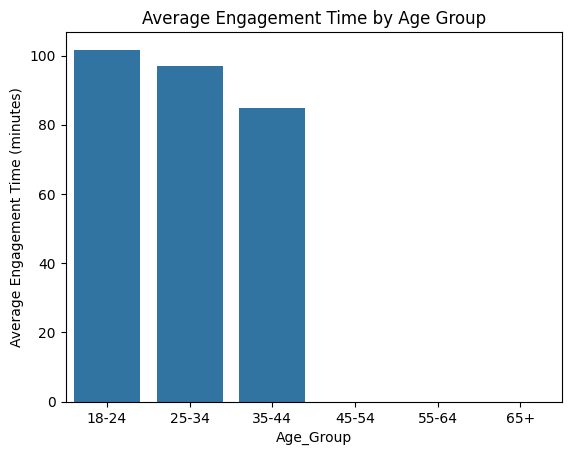

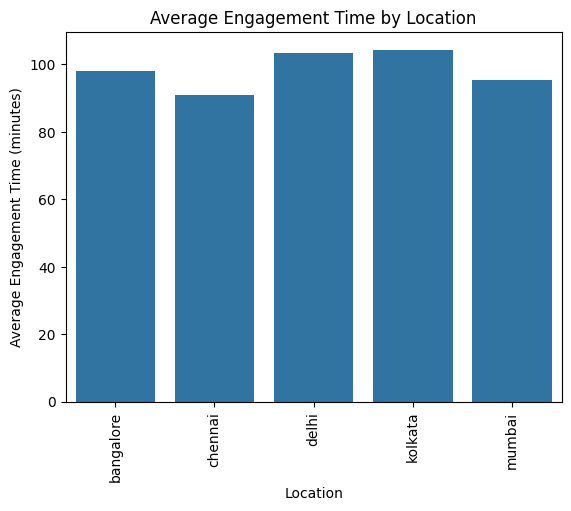

Course_ID
DM101    2.900000
PY202    3.277778
UX303    2.923077
WD404    2.789474
Name: Rating, dtype: float64
                       Completion_Percentage    Rating
Completion_Percentage               1.000000 -0.051708
Rating                             -0.051708  1.000000
  engagement_segment satisfaction_segment  count
6               High                  Low     21
4             Medium               Medium     20
1                Low               Medium     17


<ipython-input-16-9c19526c1c69>:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_segments = merged_data_feedback.groupby(['engagement_segment', 'satisfaction_segment']).size().reset_index(name='count')


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming dataframes are loaded: students, course_activity, feedback

# 1. What is the overall average completion rate across courses?
average_completion_rate = course_activity['Completion_Percentage'].mean()
print(f"Overall average completion rate: {average_completion_rate:.2f}")

# 2. Which course has the highest and lowest average engagement time?
avg_engagement_time_per_course = course_activity.groupby('Course_ID')['Time_Spent_Minutes'].mean()
highest_engagement_course = avg_engagement_time_per_course.idxmax()
lowest_engagement_course = avg_engagement_time_per_course.idxmin()
highest_engagement_time = avg_engagement_time_per_course.max()
lowest_engagement_time = avg_engagement_time_per_course.min()
print(f"Course with the highest average engagement time: {highest_engagement_course} ({highest_engagement_time} mins)")
print(f"Course with the lowest average engagement time: {lowest_engagement_course} ({lowest_engagement_time} mins)")

# 3. How does engagement differ by age group or location?

# First, verify that the 'Location' column exists in the 'students' DataFrame
print(students.columns)

# Create age groups (e.g., 18-24, 25-34, etc.)
students['Age_Group'] = pd.cut(students['Age'], bins=[18, 24, 34, 44, 54, 64, 100], labels=['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], right=False)

# Merge students with course_activity to analyze engagement by age group and location
merged_data = pd.merge(course_activity, students[['Student_ID', 'Age_Group', 'Location']], on='Student_ID')

# Group by age group and calculate average engagement time
engagement_by_age_group = merged_data.groupby('Age_Group')['Time_Spent_Minutes'].mean()

# Plotting with Seaborn for age group engagement
sns.barplot(x=engagement_by_age_group.index, y=engagement_by_age_group.values)
plt.title('Average Engagement Time by Age Group')
plt.ylabel('Average Engagement Time (minutes)')
plt.show()

# Now, engagement by location (checking if 'Location' column is available)
if 'Location' in merged_data.columns:
    engagement_by_location = merged_data.groupby('Location')['Time_Spent_Minutes'].mean()

    # Plotting engagement by location
    sns.barplot(x=engagement_by_location.index, y=engagement_by_location.values)
    plt.title('Average Engagement Time by Location')
    plt.ylabel('Average Engagement Time (minutes)')
    plt.xticks(rotation=90)
    plt.show()
else:
    print("'Location' column not found in merged data.")

# 4. What is the average feedback rating per course?
average_feedback_per_course = feedback.groupby('Course_ID')['Rating'].mean()
print(average_feedback_per_course)

# 5. Is there a correlation between completion rate and feedback rating?
# Merge course_activity with feedback (using 'Rating' for feedback score)
merged_data_feedback = pd.merge(course_activity, feedback[['Student_ID', 'Course_ID', 'Rating']], on=['Student_ID', 'Course_ID'])

# Calculate the correlation between completion rate and feedback rating
correlation = merged_data_feedback[['Completion_Percentage', 'Rating']].corr()
print(correlation)

# 6. Identify top 3 student segments based on engagement and satisfaction.
engagement_percentile = pd.qcut(merged_data_feedback['Time_Spent_Minutes'], 3, labels=["Low", "Medium", "High"])
satisfaction_percentile = pd.qcut(merged_data_feedback['Rating'], 3, labels=["Low", "Medium", "High"])

merged_data_feedback['engagement_segment'] = engagement_percentile
merged_data_feedback['satisfaction_segment'] = satisfaction_percentile

top_segments = merged_data_feedback.groupby(['engagement_segment', 'satisfaction_segment']).size().reset_index(name='count')
top_segments = top_segments.sort_values(by='count', ascending=False).head(3)
print(top_segments)


3. Visualisations

<ipython-input-17-68cf8d2f6275>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  engagement_by_age_group = merged_data.groupby(['Age_Group', 'Course_ID'])['Time_Spent_Minutes'].mean().unstack()


<Figure size 1000x600 with 0 Axes>

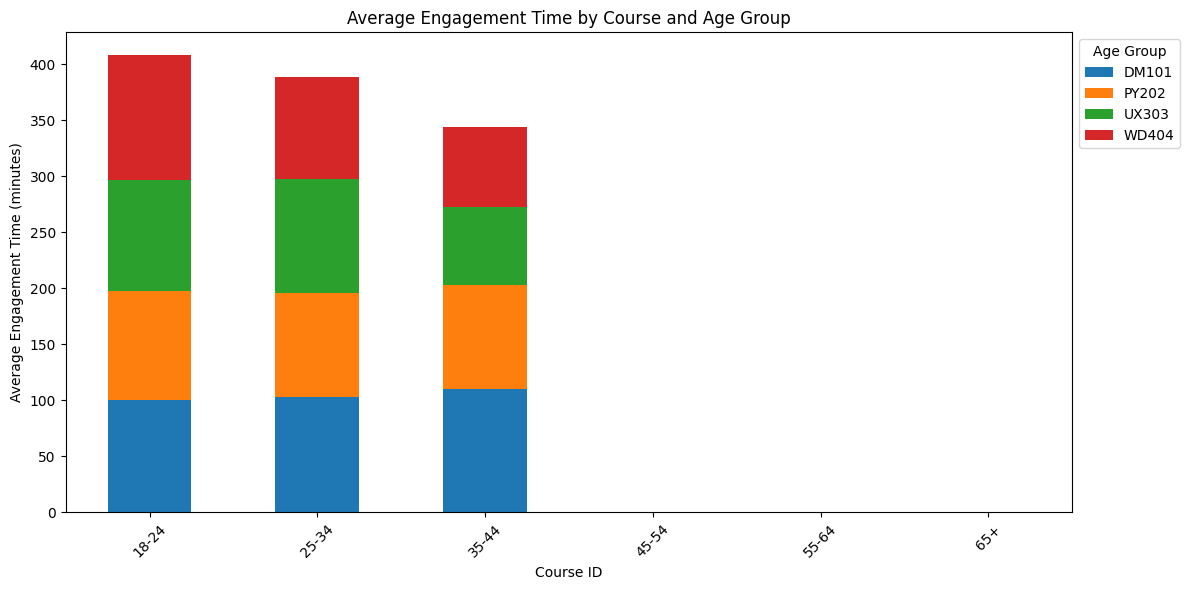

<Figure size 1000x600 with 0 Axes>

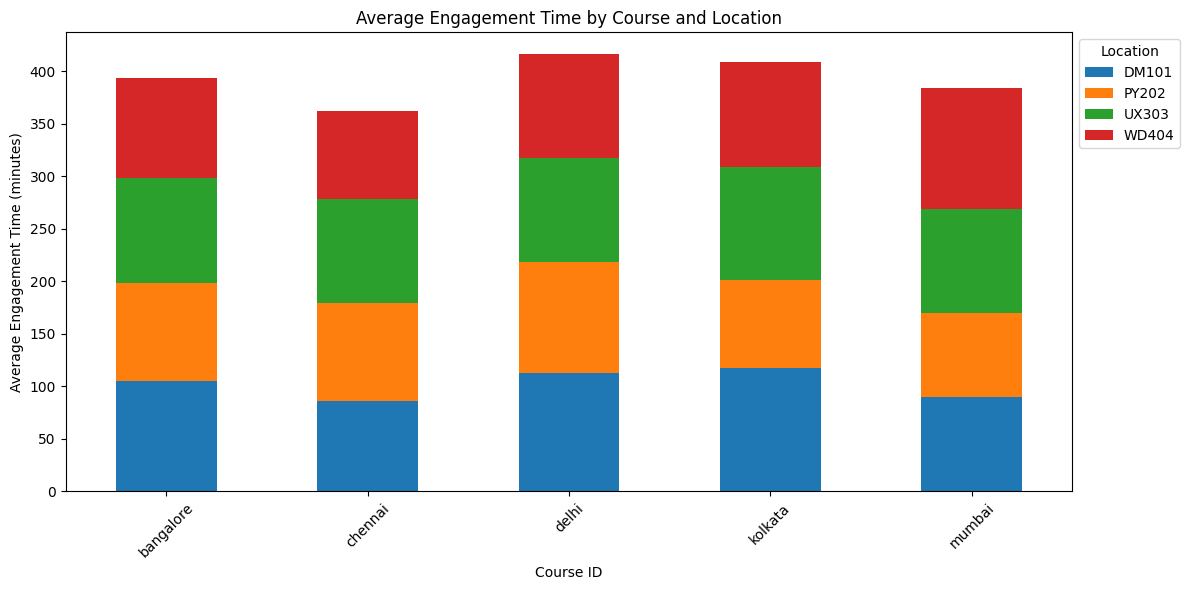

<ipython-input-17-68cf8d2f6275>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_ratings.index, y=avg_ratings.values, palette='viridis')


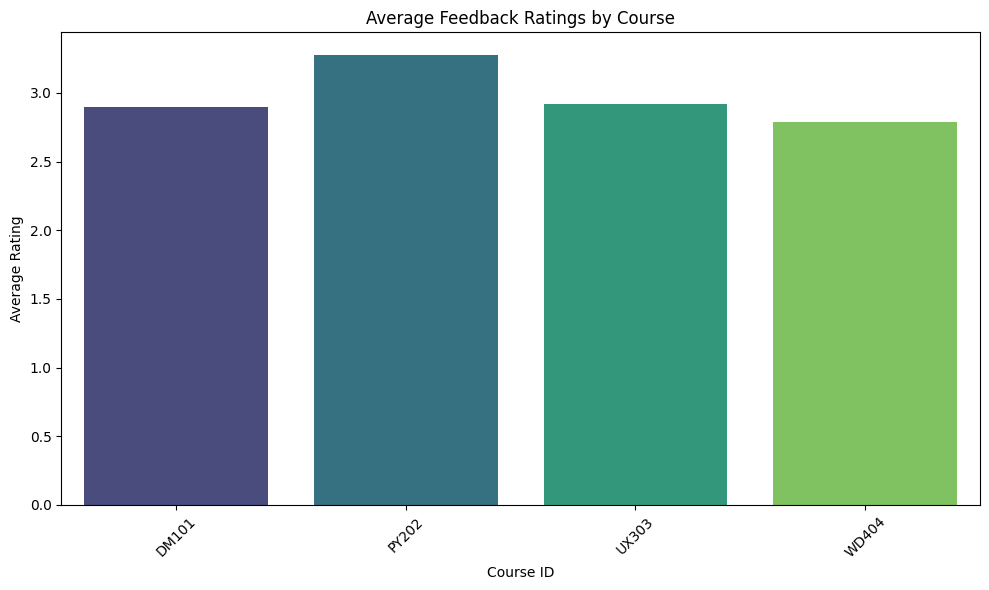

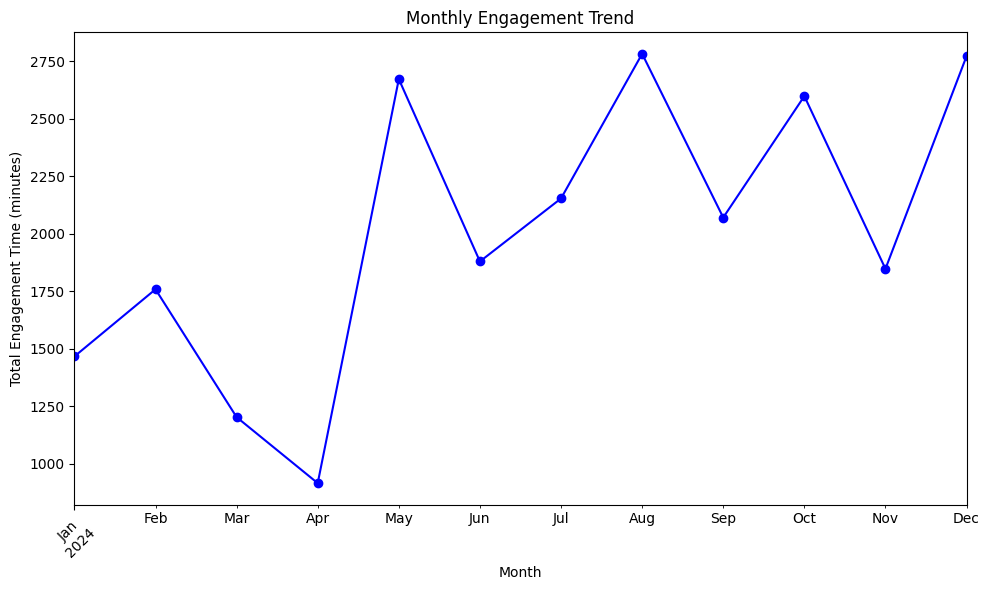

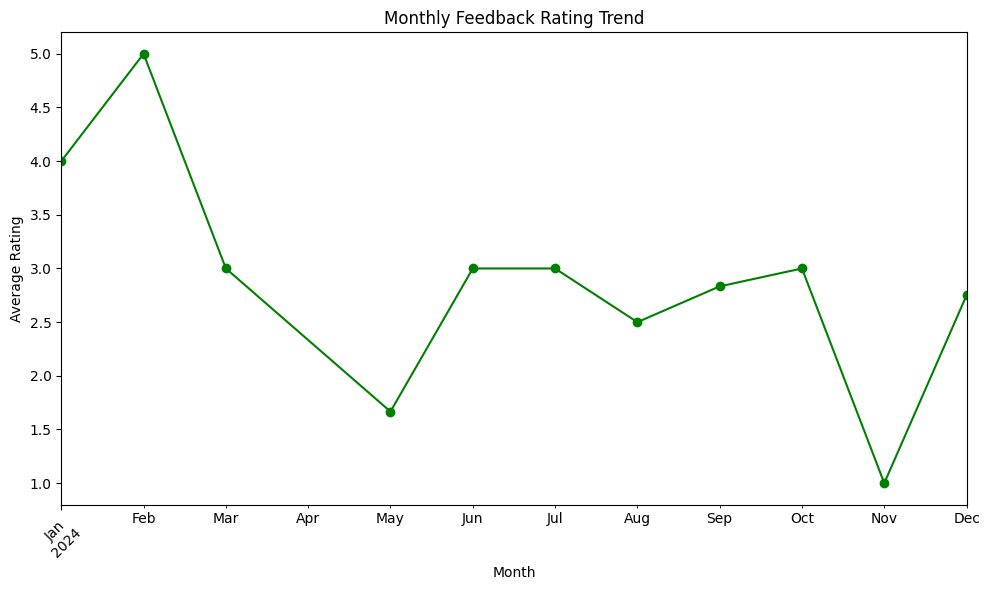

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Engagement Patterns by Course and Age Group
plt.figure(figsize=(10, 6))
engagement_by_age_group = merged_data.groupby(['Age_Group', 'Course_ID'])['Time_Spent_Minutes'].mean().unstack()
engagement_by_age_group.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Average Engagement Time by Course and Age Group')
plt.xlabel('Course ID')
plt.ylabel('Average Engagement Time (minutes)')
plt.xticks(rotation=45)
plt.legend(title='Age Group', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Engagement Patterns by Course and Location
plt.figure(figsize=(10, 6))
engagement_by_location = merged_data.groupby(['Location', 'Course_ID'])['Time_Spent_Minutes'].mean().unstack()
engagement_by_location.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Average Engagement Time by Course and Location')
plt.xlabel('Course ID')
plt.ylabel('Average Engagement Time (minutes)')
plt.xticks(rotation=45)
plt.legend(title='Location', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3. Compare Feedback Ratings by Course
plt.figure(figsize=(10, 6))
avg_ratings = feedback.groupby('Course_ID')['Rating'].mean()
sns.barplot(x=avg_ratings.index, y=avg_ratings.values, palette='viridis')
plt.title('Average Feedback Ratings by Course')
plt.xlabel('Course ID')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Trends Over Time (Engagement vs Time)
# Use merged_data's 'Date' for trends over time
if 'Date' in merged_data.columns:
    merged_data['Date'] = pd.to_datetime(merged_data['Date'], errors='coerce')
    monthly_engagement = merged_data.groupby(merged_data['Date'].dt.to_period('M'))['Time_Spent_Minutes'].sum()

    plt.figure(figsize=(10, 6))
    monthly_engagement.plot(kind='line', marker='o', color='b')
    plt.title('Monthly Engagement Trend')
    plt.xlabel('Month')
    plt.ylabel('Total Engagement Time (minutes)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Date column not found in merged_data.")

# 5. Trends Over Time (Average Rating vs Time)
# We'll simulate the Date column in feedback if it's missing
if 'Date' not in feedback.columns:
    if 'Date' in merged_data.columns:
        feedback['Date'] = np.random.choice(merged_data['Date'], size=len(feedback))
        feedback['Date'] = pd.to_datetime(feedback['Date'], errors='coerce')
    else:
        print("Cannot assign 'Date' to feedback because 'Date' is missing in both datasets.")

if 'Date' in feedback.columns:
    monthly_ratings = feedback.groupby(feedback['Date'].dt.to_period('M'))['Rating'].mean()

    plt.figure(figsize=(10, 6))
    monthly_ratings.plot(kind='line', marker='o', color='g')
    plt.title('Monthly Feedback Rating Trend')
    plt.xlabel('Month')
    plt.ylabel('Average Rating')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
